# 2nd Tutorial MD - Polymer Melt in the Kremer-Grest Model

Today we are taking a look at a simulated polymer melt in equilibrium and aim to investigate some basic properties. The melt consists of M = 100 polymer chains of equal degree of polymerization N = 30. We have a file *unwrapped.txt* containing 51 snapshots of the simulation, with each snapshot containing the coordinates of the monomers.

The simulation has been performed with the MD simulation package "LAMMPS", that is available for free and is used widely for molecular dynamics simulations. The chains here are represented in the so-called "Kremer-Grest model", which is one kind of "bead-spring model" of polymers.

### 1. Read in the file "unwrapped.txt" the trajectory of the polymer melt. First, take a look at the format of the file - what information is stored in what lines? After reading in the fold, the trajectory of the melt should be stored in a numpy array (Hint: Read it line by line).

### 2.  Extract some basic parameters of the system from the file, e.g. box dimensions, box volume, number of monomers, number density of monomers, number of chains, monomers per chain, number of snapshots, etc.

In [179]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math 
import pandas as pd

%matplotlib inline
#%%time

# define some empty lists to store data
coords = []
ts_long = []
ts_real = []

# read in file line by line
filename = 'unwrapped.txt'
ts = 0 # steps stored
read_timestep = False

# simulation parameters that are not stored in this file
dt = 0.005 # actual time step in LJ units
rcut = 1.1225
epsilon = 1.0
sigma = 1.0

with open(filename) as fn:
    for i, row in enumerate(fn):

        # read in coordinates
        if len(row.split(' ')) == 7:
            row + str(ts)
            coords.append(row.split(' ')[:-1])
            ts_long.append(ts)

        # let's also get some extra info
        if i == 3:
            Natoms = int(row)
        if i == 5:
            xdim = row.split(' ')
        if i == 6:
            ydim = row.split(' ')
        if i == 7:
            zdim = row.split(' ')
        if read_timestep == True:
            ts_real.append(np.float(row))
            read_timestep = False
        if 'TIMESTEP' in row:
            ts += 1
            read_timestep = True

# calculate the system density too maybe
coords = np.array(coords, dtype=float)   

**Now, after reading the file, let's extract some of the basic parameters and print them.**

In [180]:
# get the number of snapshots of the trajectory
steps = int(np.shape(coords)[0]/Natoms)  

# Box size
xdim = np.array(xdim, dtype=float)
ydim = np.array(ydim, dtype=float)
zdim = np.array(zdim, dtype=float)
V = (xdim[1]-xdim[0]) * (ydim[1]-ydim[0]) * (zdim[1]-zdim[0])

print("Box size:")
print("x=(",xdim[0], ", ", xdim[1], ")")
print("y=(",ydim[0], ", ", zdim[1], ")")
print("z=(",zdim[0], ", ", zdim[1], ")")
print("Box volume = ", V)

## extract a couple of values we could use
Natoms_alt = np.max(coords[:,0])
Nmol = int(np.max(coords[:,1]))
N = int(Natoms/Nmol)
Ntypes = np.max(coords[:,2])
rho = Natoms/V
delta_steps = ts_real[1] - ts_real[0]

print("Nr. of time steps = ", steps)
print("Time step increment between snapshots = ", delta_steps)
print("Time simulated [LJ units] = ", ts_real[-1]*dt)
print("Nr. of atoms = ", Natoms_alt)
print("Nr. of molecules = ", Nmol)
print("Nr of atoms / chain =",  N)
print("Nr. of atom types =", Ntypes)
print("Total monomer (number) density =", rho)

Box size:
x=( -7.630073 ,  7.630073 )
y=( -7.630073 ,  7.630073 )
z=( -7.630073 ,  7.630073 )
Box volume =  3553.66157298465
Nr. of time steps =  51
Time step increment between snapshots =  10000.0
Time simulated [LJ units] =  2500.0
Nr. of atoms =  3000.0
Nr. of molecules =  100
Nr of atoms / chain = 30
Nr. of atom types = 1.0
Total monomer (number) density = 0.8441996904844148


For a little more "convenience" we want to convert the coordinate data into a Pandas DataFrame. This is not really necessary but might be helpful. The same computations can be done of course with numpy arrays, default python lists etc. Let's try Pandas just to get a look at how it may help:

We want to add the time step as an additional column of the dataframe.
**As a first exercise with Pandas, let's extract a couple of the basic simulation parameters but in the way of Pandas.**

In [181]:
# Convert our trajectory into a dataframe
df = pd.DataFrame(coords,  columns=["id","mol","type", "x", "y", "z"])
df['id'] = df['id'].astype(np.int64)
df['mol'] = df['mol'].astype(np.int64)
df['type'] = df['type'].astype(np.int64)

# broadcasting: making the timesteps array fit the dimension of the dataframe
steps = int(np.shape(coords)[0]/Natoms)
steps_long = pd.Series(np.repeat(range(steps), Natoms))

# add another column with the (broadcasted) timesteps
df["timestep"] = steps_long

# We can extract the same information with pandas a bit more conveniently
Natoms = np.max(df["id"])
Nmol = np.max(df["mol"])
N = Natoms/Nmol
Ntypes = np.max(df["type"])

print("Nr. of atoms = ", Natoms)
print("Nr. of molecules = ", Nmol)
print("Nr of atoms / chain =",  N)
print("Nr. of atom types =", Ntypes)
print("Total monomer (number) density =", rho)

Nr. of atoms =  3000
Nr. of molecules =  100
Nr of atoms / chain = 30.0
Nr. of atom types = 1
Total monomer (number) density = 0.8441996904844148


**Let's take a look at the Kremer-Grest model and the FENE-Potential.**

In the Kremer-Grest Model the monomers (also called "beads" or "atoms") within a chain are connected via a bonding potential. In general, the simplest choice would be a harmonic spring potential. This may lead to unphysical results though because it can be stretched very far under some conditions, leading to unphysical results. That is why the Kremer-Grest model uses the so-called FENE potential (Finite Extensible Nonlinear Elastic):

\begin{equation} U_{\mathrm{FENE}}(r) = -\frac{1}{2} K \cdot r_0 \cdot \ln{\left( 1 - \frac{r}{r_0} \right)}, \quad r<r_0 \end{equation}

Looking at neighboring bonded monomers, they are connected by the FENE potential while the Lennard-Jones (LJ) potential (see previous exercise) is also acting as a pair potential between them. That means, two potentials are acting on them.

### 3. Plot the FENE potential and the LJ Potential as well as their sum. Find out the minimum of the combination of LJ+FENE and print it to the screen.

Minimum of the (full) bonding potential: X =  0.9690000000000001 , Y =  24.370218046203316


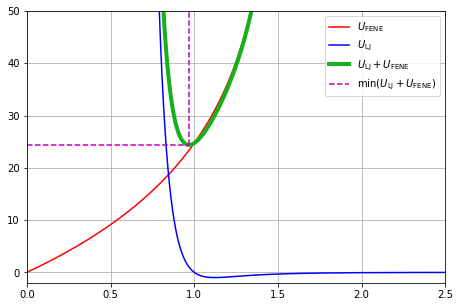

In [182]:
def U_fene(r, r_0, K):
    return -0.5 * K * r_0 * np.log(1. - r/r_0)

def U_LJ(r, epsilon, sigma):
    return 4.*epsilon * ( (sigma/r)**12 - (sigma/r)**6  )

plt.figure(0, figsize=(7.5,5))
x = np.arange(0.0001,1.49, step=0.0001)
xLJ = np.arange(0.0001,3.0, step=0.0001)
plt.plot(x, U_fene(x, 1.5, 30), 'r-', label=r"$U_{\mathrm{FENE}}$")
plt.plot(xLJ, U_LJ(xLJ, 1.0, 1.0), 'b-', label=r"$U_{\mathrm{LJ}}$")
plt.plot(x, U_LJ(x, 1.0, 1.0) + U_fene(x, 1.5, 30), c="xkcd:green", label=r"$U_{\mathrm{LJ}} +U_{\mathrm{FENE}}$", lw=4.0)

U_intra = U_LJ(x, 1.0, 1.0) + U_fene(x, 1.5, 30)
Y_min = np.min(U_LJ(x, 1.0, 1.0) + U_fene(x, 1.5, 30))
id_min = np.where(U_intra == Y_min)[0][0]
X_min = x[id_min]

print("Minimum of the (full) bonding potential: X = ", X_min, ", Y = ", Y_min)

plt.plot([X_min, X_min],[Y_min, 100], 'm--')
plt.plot([0, X_min],[Y_min,Y_min], 'm--', label = r"$\min\left(U_{\mathrm{LJ}} +U_{\mathrm{FENE}}\right)$" )

plt.axis([0,2.5, -2, 50])
plt.grid()
plt.legend(loc="best", frameon=True)
plt.show()

Let's compare the "expected" average bond length as determined above to the average bond length in our simulation.

### 4. Assuming we are in equilibrium, calculate the average bond length of the simulated melt.

In [183]:
# get the difference in x,y,z-coordinates between neighboring rows = bond vector
bond_r = df[["mol", "x", "y", "z"]].diff().dropna()

# kick out the rows, where the "jump" to the next molecule appears
# also take the square of the values
bond_r2 = bond_r[bond_r["mol"] != 1.0]**2

# get the length of the bond vector and average over the whole system
bond_l = bond_r2.sum(axis=1).apply(np.sqrt).mean()

# print the result to the screen
print("Average bond length = ", bond_l)

Average bond length =  1.0016124900551722


Moving on, we want to measure some more observables and also find out about how good our sampling is.

### 5. a) Calculate the end-to-end distance vector $\vec{R}$  of the chains  (and its average $\langle \vec{R} \rangle$ ) as well as its average length $R$. What values are to be expected? 

### 5. b) Use this calculation to also find the autocorrelation function of the end-to-end vector $\langle \vec{R(0)} \cdot \vec{R(t)} \rangle$.

In [184]:
#%%time
# end to end vector

N = int(N)
R_ee_abs = pd.DataFrame([])
R_ee_acorr = pd.DataFrame([])
R_ee_vec_mean = [0,0,0]

for j in range(Nmol): # range(Nmol): # loop only over molecules
    
    # let's get a "subset" of that dataframe, containing only the information of molecule j
    mymol = df[['id','mol','timestep', 'x', 'y', 'z']].loc[((df['mol'] == j+1))]
    #print(mymol)
    
    #grouped = mymol.groupby('timestep')[['x', 'y', 'z']]
    #print(grouped)
    
    # get the coordinates of the first and last monomer of molecule j
    r_i = mymol[['x', 'y', 'z']].loc[mymol["id"] == 1+j*N]  
    r_f = mymol[['x', 'y', 'z']].loc[mymol["id"] == N+j*N]

    # calculate the distance vector between the first and last monomer
    r_ee_vec = pd.DataFrame(r_i.values - r_f.values)
    
    # lets sum up the vectors to later get the average R-ee vector
    R_ee_vec_mean += r_ee_vec.mean()
    
    # get correlation function for each end to end vector
    r_acorr = (r_ee_vec.iloc[0,:] * r_ee_vec.iloc[:,:]).sum(axis=1)
    R_ee_acorr[str(j+1)] = r_acorr
    
    # get the (squared) length of this vector
    r_ee_abs = r_ee_vec.apply(np.square).sum(axis=1) #.apply(np.sqrt)
    
    R_ee_abs[str(j+1)] = r_ee_abs # the whole matrix of end-to-end distances (absolute values, not vectors!)
    
#print(R_ee_abs)
R_ee_avg_acorr = R_ee_acorr.mean(axis=1) # correlation function vs. time (ensemble average over all chains)
R_ee_vec_mean /= Nmol # average of end to end dist. vector


print("average end to end distance vector [LJ units]:")
print(R_ee_vec_mean)

print("average end to end distance [LJ units]:")
print(np.sqrt(r_ee_abs.mean()))

average end to end distance vector [LJ units]:
0    0.566901
1   -0.122022
2   -0.182294
dtype: float64
average end to end distance [LJ units]:
7.3341485399723405


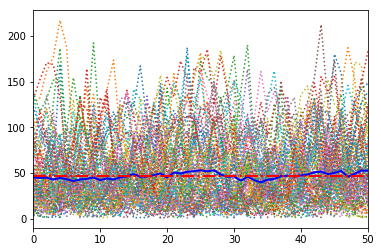

In [185]:
# Plotting the absolute values

# plot all columns at once
R_ee_abs.plot(linestyle=':')

#plot average curve of all
R_ee_abs.mean(axis=1).plot(c="b", label=r"$\langle R_e^2(t) \rangle$", lw=2.0)

# plot average value
plt.plot(np.arange(steps), np.ones(steps)*R_ee_abs.mean().mean(), 'r-.', lw=2.0, label=r"$\langle R_e^2 \rangle_t$")
plt.legend(ncol=5).remove()


**5 b) Next, we plot the  autocorrelation function of the end to end distance and find out the Rouse time of the system.**
$\vec{R}$ is reorienting over time. The autocorrelation function of $\vec{R(t)}$ is calulated as

\begin{equation}
\langle \vec{R(0)} \cdot \vec{R(t)} \rangle
\end{equation}

and can tell us how the relaxation of this vector is proceeding. Typically it can be fitted to a time-dependent exponential function of the form

\begin{equation}
\langle \vec{R(0)} \cdot \vec{R(t)} \rangle  \approx \exp({-t/\tau_1})
\end{equation}

The parameter $\tau_1$ is a typical time scale of this exponential decay and defines the longest relaxation time in the system and is also called "Rouse time". (There are many relaxation times in such a system, e.g. the  monomer relaxation time is much much shorter). After the time $\tau_1$ the end-to-end distance has "relaxed", i.e. can be treated as uncorrelated to its value at t=0. We can find out how many uncorrelated samples we can extract from out simulation

Estimates for relaxation time (Rouse time) in LJ units: 1066.5066212042739 801.6164554038609
Samples are uncorrelated (roughly) after  213301.32424085477 or 160323.29108077218 steps.
We can extract about  2.3441017151652184 or 3.1186984537891997  uncorrelated samples from this simulation.


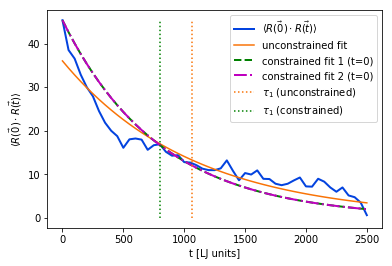

In [186]:
from scipy.optimize import curve_fit

# define function to fit to:
def exp_fit(x,a,b):
    return a * np.exp(-1. * x / b)

# for convenience, define x and y of our original data
x = np.array(R_ee_avg_acorr.index)
y = np.array(R_ee_avg_acorr)

# fitting using scipy.optimize.curve_fit
# popt = optimal parameters for fit
# pcov = covariance matrix of fit
popt, pcov = curve_fit(exp_fit, x, y, [10.,10.])
tau = popt[1]*delta_steps # tau = b
tau_LJ = popt[1]*delta_steps*dt

# generate y data of fitted curve
y_fit = exp_fit(x,popt[0], popt[1])


# fitting using constraints
# make fitted curve have same value at t = 0 as real data
y_weight = np.ones(len(x))*100
y_weight[0] = 0.001
popt2, pcov2 = curve_fit(exp_fit, x, y ,[10., 10.], sigma = y_weight, absolute_sigma = True)
y_fit2 = exp_fit(x,popt2[0], popt2[1])
tau_2 = popt2[1]*delta_steps # tau = b
tau_2_LJ = popt2[1]*delta_steps*dt # tau = b


#alternative method: fix a
popt3, pcov3 = curve_fit(exp_fit, x, y , bounds = ([y[0]-0.0001, -np.inf],[y[0]+0.0001, np.inf]))
y_fit3 =  exp_fit(x,popt3[0], popt3[1])
tau_3 = popt2[1]*delta_steps
tau_3_LJ = popt2[1]*delta_steps*dt

# lets do the plotting

plt.plot(x*dt*delta_steps, y, c='xkcd:blue', lw=2., label=r"$\langle \vec{R(0)} \cdot \vec{R(t)} \rangle$")
plt.plot(x*dt*delta_steps, y_fit, c="xkcd:orange", label="unconstrained fit")
plt.plot(x*dt*delta_steps, y_fit2, 'g--', lw=2., label="constrained fit 1 (t=0)")
plt.plot(x*dt*delta_steps, y_fit3, 'm-.', lw=2., label="constrained fit 2 (t=0)")
plt.plot([tau_LJ, tau_LJ], [0, y[0]], c="xkcd:orange", ls=":", label=r"$\tau_1$ (unconstrained)")
plt.plot([tau_2_LJ, tau_2_LJ], [0, y[0]], 'g:', label=r"$\tau_1$ (constrained)")
plt.legend(loc="best")
plt.xlabel("t [LJ units]")
plt.ylabel(r"$\langle \vec{R(0)} \cdot \vec{R(t)} \rangle$")

print("Estimates for relaxation time (Rouse time) in LJ units:",tau_LJ, tau_2_LJ)
print("Samples are uncorrelated (roughly) after ", tau ,"or", tau_2 ,"steps.")
print("We can extract about ", (ts_real[-1]*dt)/tau_LJ ,"or", (ts_real[-1]*dt)/tau_2_LJ ," uncorrelated samples from this simulation.")

### 6. Next, we want to calculate the average radius of gyration of the polymer chains.

Radius of gyration can be calulated by the formula 
\begin{equation}
R_g^2 = \frac{1}{N} \sum_{i=1}^{N} \left( \vec{R_i}  - \vec{R_{cm}} \right)^2 .
\end{equation}

Here, we have to insert the center of mass of the chain, 
\begin{equation}
\vec{R_{cm}} = \frac{1}{N} \sum_{j=1}^{N} \vec{R_j} .
\end{equation}

Alternatively, one can calulate the radius of gyration via (see also: Rubinstein, Colby "Polymer Physics"):
\begin{equation}
R_g^2 = \frac{1}{2N} \sum_{i=1}^{N} \sum_{j=i}^{N} \left( \vec{R_i}  - \vec{R_{j}} \right)^2 .
\end{equation}

That means we calculate the radius of gyration of each chain at each time. Then we perform an averaging, which is a combination of ensemble average and time average.


In [187]:
## At first, let's do it the "old school" way using two loops over time and over molecule id
rg2 = []
for i in range(steps): # loop over time
    for j in range(Nmol): # loop over molecule id
        
        # select only the current molecule coordinates
        coords_loc = df[['x', 'y', 'z']].loc[((df["mol"] == j+1)) & ((df["timestep"] == i))]
        
        # center of mass
        com_loc = coords_loc.sum()/N
        
        # squared radius of gyration
        rg2_loc = coords_loc.sub(com_loc).apply(np.square).sum(axis=1).sum()/N
        rg2.append([i, j+1, rg2_loc])

Rg2 = pd.DataFrame(rg2,  columns=["timestep","mol", "RG2"])
#print(Rg2)

The method shown above takes veeeeeeeeery long. **Let's do it faster** by avoiding multiple loops, and rather using as much vectorized code as we can. Also, we can get the array in a more useful shape for analysis.

In [189]:
#%%time

myRg2 = pd.DataFrame(np.arange(steps), columns=['timestep'])

for j in range(Nmol): # only one loop now over molecule ids now
    
    mymol = df[['timestep', 'x', 'y', 'z']].loc[((df['mol'] == j+1))].reset_index(drop=True)
    
    com_loc = mymol.groupby('timestep')[['x', 'y', 'z']].mean()
    
    com_rep = com_loc.iloc[np.repeat(np.arange(len(com_loc)), int(N))].reset_index(drop=True)

    rg2_loc = mymol[['x', 'y', 'z']] - com_rep[['x', 'y', 'z']]
    
    rg2 = pd.DataFrame(rg2_loc.apply(np.square).sum(axis=1), columns=['r_dist2'])
    rg2['timestep'] = mymol['timestep']
    rg2_vs_t = rg2.groupby('timestep')['r_dist2'].mean()

    # append to dataframe (can also be slow)
    myRg2[str(j+1)] = rg2_vs_t


myRg2.reset_index(drop=True)
#print(myRg2.describe())

,timestep,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0,4.528631,9.897365,3.956376,12.861320,4.435008,5.544131,4.711139,14.812459,15.233971,...,17.282656,7.458966,6.968452,7.116208,18.484012,3.678449,6.263488,8.755639,8.466065,4.659538
1,1,3.656222,8.926121,4.064819,9.474512,5.451756,6.700110,4.285999,12.853698,16.255956,...,14.177035,7.693625,13.778000,9.582933,17.516869,3.409949,9.585329,11.105603,8.179141,5.364208
2,2,4.529275,9.062773,3.602783,7.583712,5.410613,7.827461,8.268937,14.638661,14.420165,...,13.596428,5.003143,10.061401,4.381517,18.894281,4.302608,6.771313,11.355524,7.757071,7.061189
3,3,4.875169,8.408571,3.593787,6.001749,4.973669,5.626127,7.637057,11.904165,7.758206,...,10.811708,4.560811,12.116875,4.701004,16.771297,3.864727,7.018771,7.919579,5.074892,5.119772
4,4,5.771695,6.083943,3.909442,10.938157,3.660910,3.773479,5.305198,8.177035,5.943209,...,8.489789,3.356510,14.264056,5.425614,14.713646,4.772374,8.899118,12.416443,5.869451,5.852439
5,5,4.483130,7.614972,3.851158,9.634415,4.596918,6.155470,5.603056,7.196529,10.296425,...,11.095253,3.933938,13.122784,7.584058,12.535776,5.186845,7.178282,9.555648,4.672506,4.065963
6,6,5.471057,8.008643,4.644472,9.860930,3.260410,6.302229,4.270789,8.614453,12.074227,...,10.084077,4.615621,9.196408,7.228935,10.321615,4.647719,7.244521,11.265826,3.275557,4.975979
7,7,7.391644,8.352880,3.438558,7.427842,3.325855,4.031683,5.751983,7.109482,12.676877,...,5.742000,7.608702,14.964998,8.323115,8.899495,6.615670,7.393426,7.385491,3.429230,6.831732
8,8,6.733704,9.149075,4.916057,8.150801,4.473577,3.075845,5.800388,7.748246,10.715483,...,6.662309,9.094868,10.885842,9.367572,11.060668,8.003251,8.731827,6.636352,5.879182,5.761127
9,9,7.722678,5.089548,6.074243,8.384548,4.615656,4.548996,4.079016,10.904633,9.807037,...,7.873354,9.703317,8.088385,8.648100,11.500561,9.362664,8.742542,6.289606,5.738801,8.518949


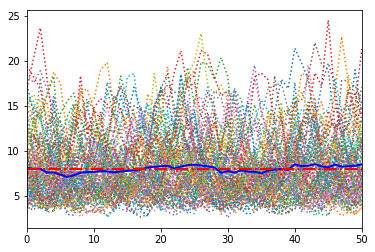

In [191]:
# plotting
myRg2.drop(columns=['timestep']).plot(linestyle=':')

#plot average curve of all
myRg2.mean(axis=1).plot(c="b", label=r"$\langle R_g^2(t) \rangle$", lw=2.0)

# plot average value
plt.plot(np.arange(steps), np.ones(steps)*myRg2.mean().mean(), 'r-.', lw=2.0, label=r"$\langle R_g^2 \rangle_t$")

plt.legend(ncol=5).remove()


### 7. Compare the (squared) radius of gyration and the (squared) end to end distance. What is the ratio between them? Can we verify this value?

<R²> / <Rg²>  =  5.911380385240574


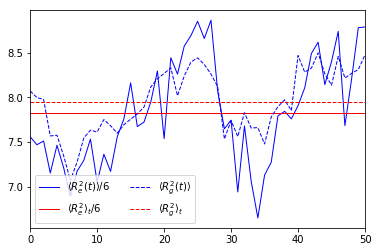

In [192]:
#plot average curve of all
R_ee_abs.mean(axis=1).div(6.).plot(c="b", label=r"$\langle R_e^2(t) \rangle / 6$", lw=1.0)

# plot average value
plt.plot(np.arange(steps), np.ones(steps)*R_ee_abs.div(6.).mean().mean(), 'r', lw=1.0, label=r"$\langle R_e^2\rangle_t / 6$")


#plot average curve of all
myRg2.mean(axis=1).plot(c="b", ls="--", label=r"$\langle R_g^2(t) \rangle$", lw=1.0)
 
# plot average value
plt.plot(np.arange(steps), np.ones(steps)*myRg2.mean().mean(), 'r--', lw=1.0, label=r"$\langle R_g^2 \rangle_t$")

plt.legend(ncol=2)

print("<R²> / <Rg²>  = ", R_ee_abs.mean().mean()/myRg2.mean().mean())